In [1]:
import numpy as np
import pandas as pd
import os
import torch 
from torch import nn, optim 
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torch.utils.data
import matplotlib.pyplot as plt
import time
import itertools
import glob 
from PIL import Image
import csv 
import cv2
import re
from torchvision.transforms import functional as F
from torchvision.ops.boxes import box_iou
import random
import torchvision

In [2]:
!pip install --upgrade albumentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
!git clone https://github.com/lessw2020/Ranger-Deep-Learning-Optimizer
%cd Ranger-Deep-Learning-Optimizer
!pip install -e .
from ranger import Ranger  
%cd ..
#https://paperswithcode.com/paper/sharpness-aware-minimization-for-efficiently-1
!git clone https://github.com/davda54/sam.git
%cd sam
import sam
print("Imported SAM Successfully from github .py file")
%cd ..
!pip install -U pytorch_warmup
import pytorch_warmup as warmup

     |████████████████████████████████| 81kB 5.6MB/s 
     |████████████████████████████████| 952kB 10.7MB/s 
     |████████████████████████████████| 37.6MB 79kB/s 
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


Cloning into 'Ranger-Deep-Learning-Optimizer'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 135 (delta 34), reused 19 (delta 6), pack-reused 69
Receiving objects: 100% (135/135), 181.12 KiB | 12.94 MiB/s, done.
Resolving deltas: 100% (59/59), done.
/content/Ranger-Deep-Learning-Optimizer
Obtaining file:///content/Ranger-Deep-Learning-Optimizer
  Running setup.py develop for ranger
/content
Cloning into 'sam'...
remote: Enumerating objects: 121, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (99/99), done.
remote: Total 121 (delta 51), reused 46 (delta 16), pack-reused 0
Receiving objects: 100% (121/121), 634.81 KiB | 3.17 MiB/s, done.
Resolving deltas: 100% (51/51), done.
/content/sam
Imported SAM Successfully from github .py file
/content


In [3]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(seed = 42)

In [4]:
from google.colab import drive
drive.mount("/content/drive/", force_remount = True)

Mounted at /content/drive/


## To Do: 

### Get the google collab pipeline onto a python script. Look at paperswithcode to see how typical projects split their code (datasets.py / train.py etc.).

### (Get more different fruits and vegetables dataset) Find and Download a lot more data that have bad spots and healthy etc. (Look at the download instructions).   Like 75 healthy vs 25 unhealthy around for each fruit or vegetable.

### Try to focus on the finetuning the model using andrej karpathy's blog http://karpathy.github.io/2019/04/25/recipe/. Record results spreadsheet.
 * Overfit one batch and try to implement input baseline from previous notebook
 * Some ideas that I could try are adding a validation loss and setting learning rate scheduler in tune with that 
 * Try Creative Augmentations for obtaining more data this can be GANS or something from the andrej karpathy link 
 * Try a larger model
 * Try running ensembles as mentioned in andrej karpathy link.

 

### Try to run model without differing bad spots. 

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 

## Links 
* Model: 
https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
https://kaggle.com/kshitijpatil09/pytorch-mean-absolute-precision-calculation?scriptVersionId=40816383

* Metrics: 
https://manalelaidouni.github.io/manalelaidouni.github.io/Evaluating-Object-Detection-Models-Guide-to-Performance-Metrics.html#precision




In [11]:
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/LatestFruitDataset.zip", 'r') as zip_ref:
    zip_ref.extractall()

In [12]:
#For one strawberry batch please drop watermark rows
strawberry_csv_batch_3 = pd.read_csv("/content/Fruit Defects Dataset /Train/FreshStrawberries/Fresh StrawBerry Batch 3 Labeled/FreshStrawberryBatch3Labels.csv", header = None)
strawberry_csv_batch_2 = pd.read_csv("/content/Fruit Defects Dataset /Train/FreshStrawberries/Fresh StrawBerry Batch 2 Labeled/FreshStrawberriesBatch2Labels.csv", header = None)
strawberry_csv_batch_1 = pd.read_csv("/content/Fruit Defects Dataset /Train/FreshStrawberries/Fresh StrawBerry Batch 1 Labeled/Strawberrybatch1.csv", header = None)
rottenApple_csv_batch_1 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenApples/RottenAppleBatch1Labeled/RottenAppleBatch1Labels.csv", header = None)
rottenApple_csv_batch_2 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenApples/RottenAppleBatch2Labeled/RottenApplesBatch2Labels.csv", header = None)
rottenApple_csv_batch_3 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenApples/RottenAppleBatch3Labaled/RottenApplesBatch3Labels.csv", header = None)
rottenStrawberry_csv_batch_1 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenStrawberries/Batch1RottenStrawBerryLabels/RottenStrawberriesBatch1Labels.csv", header = None)
rottenStrawberry_csv_batch_2 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenStrawberries/Batch2RottenStrawBerryLabels/RottenStrawBerryBatch2.csv", header = None)
rottenStrawberry_csv_batch_3 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenStrawberries/Batch3RottenStrawberrylabel/rottenStrawberryBtch3labels.csv", header = None)
freshApples_csv_batch_2 = pd.read_csv("/content/Fruit Defects Dataset /Train/FreshApples/FreshApplebtch2label/FreshApplesBatch2LabelsFresh.csv", header = None)
freshApples_csv_batch_1 = pd.read_csv("/content/Fruit Defects Dataset /Train/FreshApples/FreshApplesBatch1Labels/FreshAppleBatch1Labels.csv", header = None)

strawberry_csv_batch_3.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
strawberry_csv_batch_2.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
strawberry_csv_batch_1.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenApple_csv_batch_1.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenApple_csv_batch_2.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenApple_csv_batch_3.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenStrawberry_csv_batch_1.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenStrawberry_csv_batch_2.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenStrawberry_csv_batch_3.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
freshApples_csv_batch_2.columns =  ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
freshApples_csv_batch_1.columns =  ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]

#Drop some watermark data for Fresh StrawBerry Batch 1 Labeled images [59, 9, 93]

# strawberry_csv_batch_1 = strawberry_csv_batch_1[Image_id not in ["FreshStrawberries59.jpeg, FreshStrawberries9.jpeg, FreshStrawberries93.jpeg"]]
strawberry_csv_batch_1.drop(strawberry_csv_batch_1[strawberry_csv_batch_1["Image_id"] == "FreshStrawberries59.jpeg"].index, inplace = True)
strawberry_csv_batch_1.drop(strawberry_csv_batch_1[strawberry_csv_batch_1["Image_id"] == "FreshStrawberries9.jpeg"].index, inplace = True)
strawberry_csv_batch_1.drop(strawberry_csv_batch_1[strawberry_csv_batch_1["Image_id"] == "FreshStrawberries93.jpeg"].index, inplace = True)
strawberry_csv_batch_1 = strawberry_csv_batch_1.reset_index(drop=True)

#Stack all the csv files together. 
list_of_all_dataframes = [strawberry_csv_batch_1, strawberry_csv_batch_2, strawberry_csv_batch_3, rottenApple_csv_batch_1, 
                          rottenApple_csv_batch_2, rottenApple_csv_batch_3, rottenStrawberry_csv_batch_1, rottenStrawberry_csv_batch_2, 
                          rottenStrawberry_csv_batch_3, freshApples_csv_batch_2, freshApples_csv_batch_1]
fruit_df = pd.concat(list_of_all_dataframes, ignore_index = True)

total_row_sum_check = 0 
for dataframe in list_of_all_dataframes:
  total_row_sum_check += dataframe.shape[0]
print("Checked total rows from all the dataframes combined: {}".format(total_row_sum_check))
def run_dataframe_check():
  assert total_row_sum_check == fruit_df.shape[0]
  print("DataFrame shape: {}".format(fruit_df.shape))
  print("Unique Fruit Labels {}".format(fruit_df["Fruit"].unique()))
  print("Number of Unique Images {}".format(len(fruit_df["Image_id"].unique())))

run_dataframe_check()

Checked total rows from all the dataframes combined: 1100
DataFrame shape: (1100, 8)
Unique Fruit Labels ['Strawberry' 'Apples' 'Bad_Spots']
Number of Unique Images 344


In [13]:
#Specify more image types when 
def more_specific_Image_id(image_id, fruit):
  if fruit == "Bad_Spots":
    if re.search("RottenStrawberries", image_id):
      return "Strawberry_Bad_Spot"
    elif re.search("RottenApples", image_id):
      return "Apple_Bad_Spot"
    else:
      raise ValueError("Could not find a match for some of the Image_ids")

  else:
    return fruit

fruit_df["Fruit"] = fruit_df.apply(lambda row: more_specific_Image_id(row.Image_id, row.Fruit), axis = 1)

run_dataframe_check()

DataFrame shape: (1100, 8)
Unique Fruit Labels ['Strawberry' 'Apples' 'Apple_Bad_Spot' 'Strawberry_Bad_Spot']
Number of Unique Images 344


In [14]:
#Post Processing 
fruit_df = fruit_df[fruit_df["Image_id"] != "FreshStrawberries15.jpeg"]

In [15]:
bounding_box_dict = dict()
labels_dict = dict()
classes = ["Placeholder", "Apples", "Strawberry", "Apple_Bad_Spot", "Strawberry_Bad_Spot"]
# classes = ["Apples", "Strawberry", "Apple_Bad_Spot", "Strawberry_Bad_Spot"]
# classes = ["Bad_Spots", "Strawberry", "Apples"]

for row_index in range(len(fruit_df)): 
  current_image_file = fruit_df.iloc[row_index]["Image_id"]
  if current_image_file not in bounding_box_dict:
    bounding_box_dict[current_image_file] = list()
    labels_dict[current_image_file] = list()
  bounding_box_dict[current_image_file].append(fruit_df.iloc[row_index, 1:5].to_list())
  labels_dict[current_image_file].append(classes.index(fruit_df.iloc[row_index, 0]))

print(len(bounding_box_dict))
print(len(labels_dict))

343
343


## Class function + util functions

In [16]:
def ffile_path(image_id, full_image_file_paths):
  for image_path in full_image_file_paths:
    if image_id in image_path:
      return image_path

def find_area_bb(bb_coord):
  bb_coord = bb_coord.numpy()
  area_of_each_bb = list()
  for pair_of_coord in bb_coord:
    area_of_each_bb.append(
        (pair_of_coord[2] - pair_of_coord[0]) * (pair_of_coord[3] - pair_of_coord[1])
    )
  return torch.tensor(area_of_each_bb, dtype=torch.int32)

def convert_min_max(bb_coord):
  for pair_of_coord in bb_coord:
    pair_of_coord[2], pair_of_coord[3] = (pair_of_coord[0] + pair_of_coord[-2]), (pair_of_coord[1] + pair_of_coord[-1])
  return bb_coord

class FruitDetectDataset(object):
  def __init__(self, id_labels, id_bounding_boxes, transforms, mode):

    assert len(id_labels) == len(id_bounding_boxes)
    assert sorted(id_labels.keys()) == sorted(id_bounding_boxes.keys())
    self.imgs_key = sorted(id_labels.keys())

    np.random.shuffle(self.imgs_key)
    if (mode == "train"):
      self.imgs_key = self.imgs_key[:int(len(self.imgs_key) * 0.8)]
    else:
      self.imgs_key = self.imgs_key[int(len(self.imgs_key) * 0.8):]

    self.id_labels = id_labels
    self.id_bounding_boxes = id_bounding_boxes
    self.full_image_file_paths = glob.glob("/content/Fruit Defects Dataset /Train/*/*/*.jpeg")

    self.transforms = transforms

  def __getitem__(self, idx):

    img_path = ffile_path(self.imgs_key[idx], self.full_image_file_paths) 
    img = cv2.cvtColor(cv2.imread(img_path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

    boxes = convert_min_max(torch.as_tensor(self.id_bounding_boxes[self.imgs_key[idx]], dtype=torch.float32))
    
    labels = torch.as_tensor(self.id_labels[self.imgs_key[idx]], dtype=torch.int64)
    image_id = torch.tensor([idx])
    area = find_area_bb(boxes)

    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["image_id"] = image_id
    target["area"] = area
    
    #Query about transforms for labels of images
    if self.transforms: 
      sample = {
                'image': img,
                'bboxes': target['boxes'],
                'labels': labels
            }

      sample = self.transforms(**sample)
      img = sample['image']
      target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
    
    
    return img, target

  def __len__(self):
    return len(self.imgs_key)

In [17]:
# Albumentations
def get_transforms(mode):
  if (mode == "train"):
    return A.Compose([
                      A.OneOf([
                      A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                      A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9)],p=0.9),
                      A.Cutout(num_holes=8, max_h_size=32, max_w_size=32, p=0.5),
                      A.HorizontalFlip(),
                      A.VerticalFlip(), 
                      ToTensorV2()
                      ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
  elif (mode == "test"):
    return A.Compose([
                      ToTensorV2()
                      ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
  else:
    raise ValueError("mode is wrong value can either be train or test")

In [18]:
#Using this stack overflow (https://stackoverflow.com/questions/65279115/how-to-use-collate-fn-with-dataloaders)
#(Suppose for example, you want to create batches of a list of varying dimension tensors. The below code pads sequences with 0 until the maximum sequence size of the batch,)
#Collate_fn is a function that is used to process your batches before you pass it to dataloader. In my case since I have different sized images I need a way to stack batches b/c torch.stack won't work.
#So I use zip which can accept tensors of different lengths and make them stacked with the size of the lowest length list given. Therefore stacking all the images in a batch 
#Successfully unlike torch.stack and doing that processing to every batch makes collate_fn vital since I have different image sizes.

def collate_fn(batch):
  return tuple([list(a) for a in zip(*batch)])
    # return tuple(zip(*batch))

train_batch_size = 2
test_batch_size = 5

train_dataset = FruitDetectDataset(labels_dict, bounding_box_dict, get_transforms(mode = "train"), mode = "train")
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = train_batch_size, shuffle = True, collate_fn= collate_fn)

test_dataset = FruitDetectDataset(labels_dict, bounding_box_dict, get_transforms(mode = "test"), mode = "test")
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = test_batch_size, shuffle = True, collate_fn= collate_fn)


In [87]:
# COLORS = [(255, 0, 0), (0, 255, 0), (0, 0 , 255), (255, 255, 0)]
COLORS = [(0, 0, 0), (0, 255, 0), (0, 0 , 255), (255, 255, 0), (255, 0, 0)]

def draw_boxes(boxes, labels, image, infer = False, put_text = True):
    # read the image with OpenCV
    image = image.permute(1, 2, 0).numpy()
    if infer:
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    for i, box in enumerate(boxes):
        color = COLORS[labels[i]]
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, 2
        )
        if put_text:
          cv2.putText(image, classes[labels[i]], (int(box[0]), int(box[1]-5)),
                      cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2, 
                      lineType=cv2.LINE_AA)
    return image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IndexError: ignored

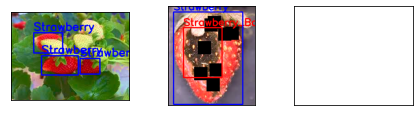

In [88]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    image = draw_boxes(labels[idx]["boxes"], labels[idx]["labels"], images[idx])
    plt.imshow(image)

## What we learned
is that the model outputs losses when in train mode 
when in model.eval model, the model code then return only a prediction with no losses.

In [22]:
def calculate_metrics(target_box,predictions_box,scores, device):

    #Get most confident boxes first and least confident last
    predictions_box = predictions_box[scores.argsort().flip(-1)]
    iou_mat = box_iou(target_box,predictions_box)
    #return a one by one matrix that is form (target_box, prediction_box) or (1, 1)
    target_boxes_count, prediction_boxes_count = iou_mat.shape
    
    mAP_Matrix = torch.zeros_like(iou_mat)
    # if not matrix coordinates that relate to nothing.
    if not iou_mat[:,0].eq(0.).all():
      index_of_biggest_iou = iou_mat[:,0].argsort()[-1]
      mAP_Matrix[index_of_biggest_iou,0] = 1

    for pr_idx in range(1,prediction_boxes_count):
        not_assigned = torch.logical_not(mAP_Matrix[:,:pr_idx].sum(1)).long()
        targets = not_assigned * iou_mat[:,pr_idx]

        if targets.eq(0).all():
            continue

        pivot = targets.argsort()[-1]
        mAP_Matrix[pivot,pr_idx] = 1

    # mAP calculation
    tp = mAP_Matrix.sum()
    fp = mAP_Matrix.sum(0).eq(0).sum()
    fn = mAP_Matrix.sum(1).eq(0).sum()

    mAP = tp / (tp+fp)
    mAR = tp / (tp+fn)

    return mAP, mAR

def run_metrics_for_batch(output, targets, mAP, mAR, missed_images, device):
  for pos_in_batch, image_pred in enumerate(output):
    assert (len(image_pred["boxes"]) == len(image_pred["labels"]) == len(image_pred["scores"]))
    if len(image_pred["boxes"]) != 0:
      curr_mAP, curr_mAR = calculate_metrics(targets[pos_in_batch]["boxes"], output[pos_in_batch]["boxes"], output[pos_in_batch]["scores"], device)
      mAP, mAR = mAP + curr_mAP , mAR + curr_mAR
    else:
      missed_images += 1 
  
  return mAP, mAR, missed_images

def Graph_Maker(Train_l,Test_L, print_every):
  epoch_count = range(1, len(Train_l) + 1)
  plt.title("Loss Value over Time")
  plt.xlabel("Number of {} Training Batches".format(print_every))
  plt.ylabel("Loss")
  plt.plot(epoch_count,Train_l, 'r--')
  plt.plot(epoch_count,Test_L, 'b-')
  plt.legend(['Training Loss', 'Test Loss'])
  plt.xticks(np.arange(1, len(Train_l)+1))
  plt.show()

https://pypi.org/project/pytorch-warmup/ link for doing warmup

In [119]:
def train(net, epochs, train_loader, test_loader, lr, weight_decay, 
          print_every = 6, lo_test_dataset = len(test_dataset), lo_train_dataset = len(train_dataset)):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    #Check which parameters can calculate gradients. 
    params = [p for p in net.parameters() if p.requires_grad]

    base_optimizer = Ranger
    optimizer = sam.SAM(net.parameters(), base_optimizer, lr = lr, weight_decay = weight_decay)
    
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = len(train_loader) * epochs)

    net.to(device)
    print("Device: {}".format(device))
    print("Optimizer: {}".format(optimizer))
    
    start_time = time.time()

    train_list = test_list = []
    
    for epoch in range(epochs):
        net.train()
        
        train_loss = steps = train_mAP = train_mAR = missed_train_images = 0
        
        for batch_idx, (images, targets) in enumerate(train_loader):
            net.train()

            steps += 1

            images = [image.to(device) for image in images]
            targets = [{key: value.to(device) for key, value in t.items()} for t in targets]

            optimizer.zero_grad()

            loss_dict = net(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            net.eval()
            train_mAP, train_mAR, missed_train_images = run_metrics_for_batch(net(images), targets, train_mAP, train_mAR, missed_train_images, device)
            net.train()

            losses.backward()
            optimizer.first_step(zero_grad = True)

            loss_dict = net(images, targets)

            losses = sum(loss for loss in loss_dict.values())
            losses.backward()
            optimizer.second_step(zero_grad = True)

            train_loss +=  losses.item()
            scheduler.step()

            if (steps % print_every) == 0:

              with torch.no_grad():
                test_mAP = test_mAR = missed_test_images = test_loss = 0

                for images, targets in test_loader:

                  net.eval()
                  if device == torch.device("cuda"):
                    images = [image.to(device) for image in images]
                    targets = [{key: value.to(device) for key, value in t.items()} for t in targets]

                  output = net(images)
                  test_mAP, test_mAR, missed_test_images = run_metrics_for_batch(output, targets, test_mAP, test_mAR, missed_test_images, device)

                  net.train()
                  test_loss_dict = net(images, targets)
                  test_losses = sum(loss for loss in test_loss_dict.values())
                  test_loss += test_losses.item()

                for param_group in optimizer.param_groups:
                  learning_rate_extract = param_group["lr"]
                print("Epoch {}/{} | Batch Number: {} | LR: {:0.2f} | Train_loss: {:0.2f} | Test_loss: {:0.2f} | Test mAP: {:0.2f}% | Test mAR: {:0.2f}% | Missed Test Images: {}".format(
                    epoch + 1, epochs, steps, learning_rate_extract, train_loss, test_loss,  
                    (test_mAP / float(lo_test_dataset)) * 100., (test_mAR / float(lo_test_dataset)) * 100.,missed_test_images))

              train_list.append(train_loss)
              test_list.append(test_loss)

              assert (steps % print_every) == 0
              train_loss = 0
                 
        print("\n Epoch {} Final Train mAP: {:0.2f}% | Epoch {} Final Train mAR: {:0.2f}% | Epoch {} Final Missed Train Images: {} out of {} images \n".format(
            epoch + 1, (train_mAP / float(lo_train_dataset)) * 100., 
            epoch + 1, (train_mAR / float(lo_train_dataset)) * 100., 
            epoch + 1, missed_train_images, lo_train_dataset
        ))
    
    print("Time for Total Training {:0.2f}".format(time.time() - start_time))
    Graph_Maker(train_list, test_list, print_every)

    return net


## This link shows the problem https://github.com/pytorch/vision/issues/2740
The answer from @oke-aditya is correct. You are probably passing to the model bounding boxes in the format [xmin, ymin, width, height], while Faster R-CNN expects boxes to be in [xmin, ymin, xmax, ymax] format.

Changing this should fix the issue.

We have btw recently added box conversion utilities to torchvision (thanks to @oke-aditya ), they can be found in

Look at box convert or doing it locally also works.

### https://github.com/pytorch/vision/blob/a98e17e50146529cdfadb590ba063e6bbee71de2/torchvision/ops/boxes.py#L137-L156




In [24]:
backbone = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True)
backbone.roi_heads.box_predictor.cls_score.out_features = 4
backbone.roi_heads.box_predictor.bbox_pred.out_features = 16
# backbone.roi_heads.box_predictor.cls_score.out_features = 3
# backbone.roi_heads.box_predictor.bbox_pred.out_features = 12


Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_320_fpn-907ea3f9.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_320_fpn-907ea3f9.pth


Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers
Device: cuda
Optimizer: SAM (
Parameter Group 0
    N_sma_threshhold: 5
    alpha: 0.5
    betas: (0.95, 0.999)
    eps: 1e-05
    initial_lr: 0.001
    k: 6
    lr: 0.001
    rho: 0.05
    step_counter: 0
    weight_decay: 0.0001
)


/content/Ranger-Deep-Learning-Optimizer/ranger/ranger.py:138: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1005.)
  exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch 1/5 | Batch Number: 30 | LR: 0.00 | Train_loss: 65.84 | Test_loss: 11.65 | Test mAP: 32.23% | Test mAR: 96.14% | Missed Test Images: 0
Epoch 1/5 | Batch Number: 60 | LR: 0.00 | Train_loss: 25.38 | Test_loss: 6.08 | Test mAP: 35.78% | Test mAR: 97.00% | Missed Test Images: 0
Epoch 1/5 | Batch Number: 90 | LR: 0.00 | Train_loss: 20.98 | Test_loss: 5.86 | Test mAP: 31.92% | Test mAR: 97.79% | Missed Test Images: 0
Epoch 1/5 | Batch Number: 120 | LR: 0.00 | Train_loss: 21.50 | Test_loss: 6.25 | Test mAP: 44.84% | Test mAR: 97.03% | Missed Test Images: 0

 Epoch 1 Final Train mAP: 33.85% | Epoch 1 Final Train mAR: 95.85% | Epoch 1 Final Missed Train Images: 0 out of 274 images 

Epoch 2/5 | Batch Number: 30 | LR: 0.00 | Train_loss: 16.80 | Test_loss: 5.51 | Test mAP: 47.29% | Test mAR: 95.64% | Missed Test Images: 0
Epoch 2/5 | Batch Number: 60 | LR: 0.00 | Train_loss: 18.59 | Test_loss: 6.20 | Test mAP: 34.60% | Test mAR: 96.48% | Missed Test Images: 0
Epoch 2/5 | Batch Number: 90 | 

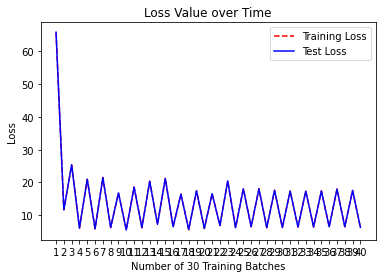

In [25]:
another_one = train(backbone, 5, train_loader, test_loader, 0.001, weight_decay = 1e-4, print_every = 30)

In [42]:
# https://github.com/amdegroot/ssd.pytorch/blob/master/layers/box_utils.py#L48
def intersect(box_a, box_b):

    A = box_a.size(0)
    B = box_b.size(0)
    max_xy = torch.min(box_a[:, 2:].unsqueeze(1).expand(A, B, 2),
                       box_b[:, 2:].unsqueeze(0).expand(A, B, 2))
    min_xy = torch.max(box_a[:, :2].unsqueeze(1).expand(A, B, 2),
                       box_b[:, :2].unsqueeze(0).expand(A, B, 2))
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def jaccard_iou(box_a, box_b):

    inter = intersect(box_a, box_b)
    area_a = ((box_a[:, 2]-box_a[:, 0]) *
              (box_a[:, 3]-box_a[:, 1])).unsqueeze(1).expand_as(inter)  # [A,B]
    area_b = ((box_b[:, 2]-box_b[:, 0]) *
              (box_b[:, 3]-box_b[:, 1])).unsqueeze(0).expand_as(inter)  # [A,B]
    union = area_a + area_b - inter
    return inter / union  # [A,B]

def calculate_iou_on_label(results, len_of_results, iou_thresh, device):
  for current_index, _ in enumerate(results["boxes"]):
    if current_index >= len_of_results:
      break

    current_index_iou = jaccard_iou(results["boxes"][current_index].view(1, -1).to(device),
                                    results["boxes"].to(device))
    
    mask = (current_index_iou > iou_thresh) & (current_index_iou != 1)
    mask = mask.squeeze()
    for key in results:
      results[key] = results[key][~mask]

    len_of_results -= sum(mask)
  
  return results

In [124]:
def infer_image(image_file_path, trained_model, distance_thresh, iou_thresh, show_image = True):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  #Just load it up as PIL. Avoid using cv2 because do not need albumentations
  torch_image = F.to_tensor(Image.open(image_file_path).convert("RGB")).unsqueeze(0).to(device)
  trained_model.to(device)
  trained_model.eval()
  print("Image Size: {}".format(torch_image.size()))

  start_time = time.time()
  results = trained_model(torch_image)
  end_time = time.time() - start_time

  print("Time of Inference {:0.2f}".format(end_time))

  valid_box_count = 0
  for ii, score in enumerate(results[0]["scores"]):
    if score < distance_thresh:
      low_index_start = ii
      break
    else:
      valid_box_count += 1

  if valid_box_count == len(results[0]["scores"]):
    low_index_start = len(results[0]["scores"])
  
  for key in results[0]:
    results[0][key] = results[0][key][:low_index_start]
  
  fruit_spot_iou_thresh, bad_spot_iou_thresh = iou_thresh
  bad_spot_index = [ii for ii, label in enumerate(results[0]["labels"]) if label == 3 or label == 4]
  fruit_index = [ii for ii, _ in enumerate(results[0]["labels"]) if ii not in bad_spot_index]

  bad_spot_results, fruit_results = dict(), dict()

  for key in results[0]:
    bad_spot_results[key], fruit_results[key] = results[0][key][[bad_spot_index]], results[0][key][[fruit_index]]

  assert len(bad_spot_results["boxes"]) == len(bad_spot_results["scores"]) == len(bad_spot_results["labels"])
  assert len(fruit_results["boxes"]) == len(fruit_results["scores"]) == len(fruit_results["labels"])

  len_of_bad_spots, len_of_fruit = len(bad_spot_results["boxes"]), len(fruit_results["boxes"])

  if len_of_bad_spots > 1:
    bad_spot_results = calculate_iou_on_label(bad_spot_results, len_of_bad_spots, bad_spot_iou_thresh, device)
  if len_of_fruit > 1:
    fruit_results = calculate_iou_on_label(fruit_results, len_of_fruit, fruit_spot_iou_thresh, device)
  
  for key in results[0]: 
    if (key == "boxes"):
      results[0]["boxes"] = torch.cat((fruit_results["boxes"], bad_spot_results["boxes"]), axis = 0)
    else:
      results[0][key] = torch.cat((fruit_results[key], bad_spot_results[key]), dim = 0)

  if show_image:
    if device == torch.device("cuda"):
      torch_image = torch_image.cpu() 
    plt.imshow(cv2.cvtColor(draw_boxes(results[0]["boxes"], results[0]["labels"], torch_image.squeeze(), infer = True, put_text= False), cv2.COLOR_BGR2RGB))
  
  return results

In [ ]:
classes

['Placeholder',
 'Apples',
 'Strawberry',
 'Apple_Bad_Spot',
 'Strawberry_Bad_Spot']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image Size: torch.Size([1, 3, 194, 259])
Time of Inference 0.02
[{'boxes': tensor([[ 78.9624,  38.5409, 205.3159, 148.1256],
        [122.9537,  88.3571, 148.5570, 115.8720],
        [167.1335,  70.0380, 181.2762,  82.3678],
        [121.4367,  65.1395, 134.1143,  79.0827],
        [ 98.5437,  89.3496, 108.5323, 102.1824],
        [113.9782,  53.3750, 130.1487,  64.9405]], device='cuda:0',
       grad_fn=<CatBackward>), 'labels': tensor([1, 3, 3, 3, 3, 3], device='cuda:0'), 'scores': tensor([0.9967, 0.7395, 0.2898, 0.1774, 0.1682, 0.1240], device='cuda:0',
       grad_fn=<CatBackward>)}]


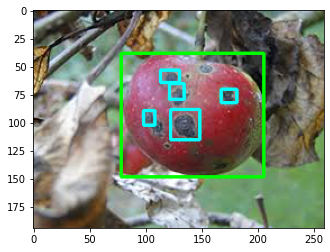

In [126]:
second_results = infer_image("/content/Fruit Defects Dataset /Train/RottenApples/RottenAppleBatch2Labeled/RottenApples118.jpeg", 
            another_one, distance_thresh = 0.1, iou_thresh = [0, 0], show_image = True)
print(second_results)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image Size: torch.Size([1, 3, 225, 225])
Time of Inference 0.02


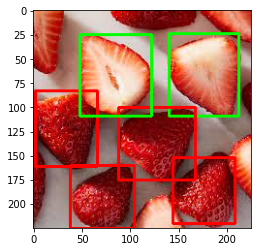

In [133]:
second_results = infer_image("/content/Fruit Defects Dataset /Predict_Examples/starwberyy.jpeg", 
            another_one, 0.2, [0.3, 0.1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image Size: torch.Size([1, 3, 529, 600])
Time of Inference 0.02
[{'boxes': tensor([[126.6341,  37.2201, 565.9055, 486.7344],
        [105.9060, 125.4348, 311.9832, 395.7924],
        [184.1083, 312.7145, 440.4134, 487.4846],
        [154.0358, 209.5149, 284.1096, 335.4995],
        [333.1024, 140.6103, 544.4350, 363.0468]], device='cuda:0',
       grad_fn=<CatBackward>), 'labels': tensor([2, 2, 2, 4, 4], device='cuda:0'), 'scores': tensor([0.8146, 0.6878, 0.2952, 0.5245, 0.5045], device='cuda:0',
       grad_fn=<CatBackward>)}]


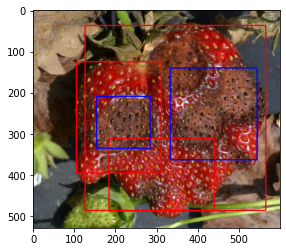

In [139]:
second_results = infer_image("/content/Fruit Defects Dataset /Predict_Examples/blobstarw.jpg", 
            another_one, 0.2, [0.3, 0.1])
print(second_results)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image Size: torch.Size([1, 3, 1274, 1300])
Time of Inference 0.02
[{'boxes': tensor([[ 158.2034,  195.0401, 1027.4482,  989.0786],
        [ 256.4378,  485.7666,  498.9083,  707.0319]], device='cuda:0',
       grad_fn=<CatBackward>), 'labels': tensor([2, 4], device='cuda:0'), 'scores': tensor([0.9645, 0.2138], device='cuda:0', grad_fn=<CatBackward>)}]


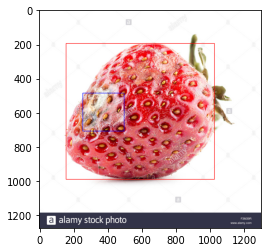

In [109]:
second_results = infer_image("/content/Fruit Defects Dataset /Predict_Examples/1starw.jpg", 
            another_one, 0.2, 0)
print(second_results)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image Size: torch.Size([1, 3, 865, 1300])
Time of Inference 0.02
[{'boxes': tensor([[211.7092, 108.9508, 941.3078, 798.1748],
        [392.3806, 340.8977, 612.3889, 527.4598]], device='cuda:0',
       grad_fn=<CatBackward>), 'labels': tensor([1, 3], device='cuda:0'), 'scores': tensor([0.9939, 0.2813], device='cuda:0', grad_fn=<CatBackward>)}]


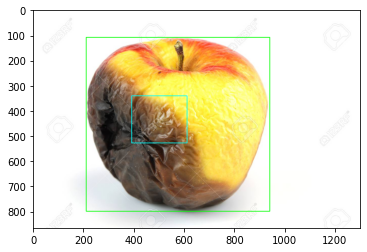

In [118]:
second_results = infer_image("/content/Fruit Defects Dataset /Predict_Examples/another_rot_app.jpg", 
            another_one, 0.2, 0)
print(second_results)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Current device: cuda
Image Size: torch.Size([1, 3, 454, 379])
[{'boxes': tensor([[ 22.4579,  71.8970, 343.5308, 424.6460],
        [185.4650, 106.0667, 333.8842, 290.9572],
        [ 74.9308, 125.0910, 328.6821, 385.3492],
        [ 80.0647,  92.0707, 162.7251, 135.4353],
        [ 17.9725,  79.4630, 337.6868, 419.4028],
        [116.6627, 281.1342, 258.1978, 345.2222],
        [ 43.9131, 155.5624, 121.3100, 237.0939],
        [136.1726, 169.9773, 178.2807, 204.9722],
        [193.8082, 145.3584, 273.4965, 267.1662],
        [139.2377, 150.2679, 176.4910, 217.8233]], device='cuda:0',
       grad_fn=<StackBackward>), 'labels': tensor([2, 4, 4, 4, 1, 4, 4, 4, 4, 4], device='cuda:0'), 'scores': tensor([0.9801, 0.4950, 0.3255, 0.2624, 0.2358, 0.1661, 0.1266, 0.0990, 0.0814,
        0.0739], device='cuda:0', grad_fn=<IndexBackward>)}]
Time of Inference 0.02
[{'boxes': tensor([[ 22.4579,  71.8970, 343.5308, 424.6460],
        [185.4650, 106.0667, 333.8842, 290.9572]], device='cuda:0',
      

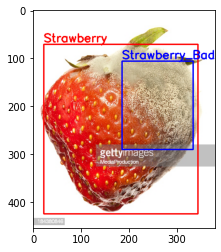

In [ ]:
def infer_image(image_file_path, trained_model, distance_thresh, iou_thresh, show_image = True):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  # print("Current device: {}".format(device))

  #Just load it up as PIL. Avoid using cv2 because do not need albumentations
  torch_image = F.to_tensor(Image.open(image_file_path).convert("RGB")).unsqueeze(0).to(device)
  trained_model.to(device)
  trained_model.eval()
  # print("Image Size: {}".format(torch_image.size()))

  start_time = time.time()
  results = trained_model(torch_image)
  end_time = time.time() - start_time

  # print(results)
  # print("Time of Inference {:0.2f}".format(end_time))

  valid_box_count = 0
  for ii, score in enumerate(results[0]["scores"]):
    if score < distance_thresh:
      low_index_start = ii
      break
    else:
      valid_box_count += 1

  if valid_box_count == len(results[0]["scores"]):
    low_index_start = len(results[0]["scores"])
  

  for key in results[0]:
    results[0][key] = results[0][key][:low_index_start]
  
  

  bad_spot_index = [ii for ii, label in enumerate(results[0]["labels"]) if label == 3 or label == 4]
  fruit_index = [ii for ii, _ in enumerate(results[0]["labels"]) if ii not in bad_spot_index]

  print(bad_spot_index)
  print(fruit_index)

  bad_spot_results, fruit_results = dict(), dict()
  #Can create two bad spots and fruit results and concat and then reorder.
  for key in results[0]:
    bad_spot_results[key], fruit_results[key] = results[0][key][[bad_spot_index]], results[0][key][[fruit_index]]
  
  print(bad_spot_results)
  print("\n")

  # #Go through every single box and do ioU with other boxes of same label (bad spot or fruit). 
  assert len(bad_spot_results["boxes"]) == len(bad_spot_results["scores"]) == len(bad_spot_results["labels"])
  assert len(fruit_results["boxes"]) == len(fruit_results["scores"]) == len(fruit_results["labels"])

  len_of_bad_spots, len_of_fruit = len(bad_spot_results["boxes"]), len(fruit_results["boxes"])
  for current_index, _ in enumerate(bad_spot_results):
    if current_index >= len_of_bad_spots:
      break
    #We are going through every bad spot prediction
    print("currently on {}".format(bad_spot_results["boxes"][current_index]))

    # Calculate iou between itself and all the bad spot indices
    current_index_iou = jaccard_iou(bad_spot_results["boxes"][current_index].view(1, -1).to(device),
                                    bad_spot_results["boxes"].to(device))
    
    print(current_index_iou)
    print("\n")
    
    mask = (current_index_iou > iou_thresh) & (current_index_iou != 1)
    mask = mask.squeeze()
    for key in bad_spot_results:
      bad_spot_results[key] = bad_spot_results[key][~mask]

    len_of_bad_spots -= sum(mask)
    print("\n")
    print(bad_spot_results)
    print("\n")


    
   




  if show_image:
    if device == torch.device("cuda"):
      torch_image = torch_image.cpu() 
    plt.imshow(cv2.cvtColor(draw_boxes(results[0]["boxes"], results[0]["labels"], torch_image.squeeze(), infer = True), cv2.COLOR_BGR2RGB))
  
  return results

In [ ]:
def infer_image(image_file_path, trained_model, distance_thresh, iou_thresh, show_image = True):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  # print("Current device: {}".format(device))

  #Just load it up as PIL. Avoid using cv2 because do not need albumentations
  torch_image = F.to_tensor(Image.open(image_file_path).convert("RGB")).unsqueeze(0).to(device)
  trained_model.to(device)
  trained_model.eval()
  # print("Image Size: {}".format(torch_image.size()))

  start_time = time.time()
  results = trained_model(torch_image)
  end_time = time.time() - start_time

  # print(results)
  # print("Time of Inference {:0.2f}".format(end_time))

  valid_box_count = 0
  for ii, score in enumerate(results[0]["scores"]):
    if score < distance_thresh:
      low_index_start = ii
      break
    else:
      valid_box_count += 1

  if valid_box_count == len(results[0]["scores"]):
    low_index_start = len(results[0]["scores"])
  

  for key in results[0]:
    results[0][key] = results[0][key][:low_index_start]
  
  

  bad_spot_index = [ii for ii, label in enumerate(results[0]["labels"]) if label == 3 or label == 4]
  fruit_index = [ii for ii, _ in enumerate(results[0]["labels"]) if ii not in bad_spot_index]

  bad_spot_results, fruit_results = dict(), dict()
  #Can create two bad spots and fruit results and concat and then reorder.
  for key in results[0]:
    bad_spot_results[key], fruit_results[key] = results[0][key][[bad_spot_index]], results[0][key][[fruit_index]]

  print(bad_spot_results)
  print("\n")

  # #Go through every single box and do ioU with other boxes of same label (bad spot or fruit). 
  assert len(bad_spot_results["boxes"]) == len(bad_spot_results["scores"]) == len(bad_spot_results["labels"])
  assert len(fruit_results["boxes"]) == len(fruit_results["scores"]) == len(fruit_results["labels"])

  len_of_bad_spots, len_of_fruit = len(bad_spot_results["boxes"]), len(fruit_results["boxes"])

  for current_index, _ in enumerate(bad_spot_results["boxes"]):
    if current_index >= len_of_bad_spots:
      break

    current_index_iou = jaccard_iou(bad_spot_results["boxes"][current_index].view(1, -1).to(device),
                                    bad_spot_results["boxes"].to(device))
    
    mask = (current_index_iou > iou_thresh) & (current_index_iou != 1)
    mask = mask.squeeze()
    for key in bad_spot_results:
      bad_spot_results[key] = bad_spot_results[key][~mask]

    print(mask)
    len_of_bad_spots -= sum(mask)

    
  print(bad_spot_results)

    
   




  if show_image:
    if device == torch.device("cuda"):
      torch_image = torch_image.cpu() 
    plt.imshow(cv2.cvtColor(draw_boxes(results[0]["boxes"], results[0]["labels"], torch_image.squeeze(), infer = True), cv2.COLOR_BGR2RGB))
  
  return results